# Camera-Trap Detection & Classification — End-to-End Project Notebook  

Welcome! This notebook is a **walk-through of my M.Sc. project** on automated wildlife monitoring for camera-trap images.  
Everything below follows the chronology of the work:

---

## What you’ll find inside  

1. **Model development**  
   * **Single-stage detectors (YOLOv8 family)** trained _from scratch_ with varying augmentation schedules.  
   * **Two-class detector (MegaDetector-v6)** fine-tuned to a simple _animal vs vehicle_ task.  
   * **Image classifiers**  
     * **ConvNeXt-ClassAware** — ViT-inspired CNN backbone with class-balanced training strategies.  
     * **EfficientNetV2-ClassAware** — EfficientNetV2 baseline extended with three CBAM attention blocks. 
   * Losses & tricks: class-balanced focal loss, weighted sampling for tail species, partial backbone freezing, noisy-crop fine-tuning.

2. **Training diagnostics**  
   * Smoothed loss curves for every run.  
   * Validation accuracy (top-1 / top-3) trends.

3. **Quantitative evaluation**  
   * Bar charts for Precision, Recall, F1, mAP-50.  
   * Domain-shift analysis — **CIS** (seen locations) vs **TRANS** (unseen).  
   * Per-class metrics & accuracy drop visualisations.

4. **Confusion-matrix deep dives**  
   * Side-by-side heat-maps for all major models and splits, annotated with key observations (rare-class issues, look-alike confusions, etc.).

5. **End-to-end pipeline tests**  
   * Detector → Classifier with confidence gating.  
   * Overall / per-class performance after threshold tuning.  
   * Rationale for the “find everything first, label second” design.

---

## Data & splits  

* **CIS** : images from stations used during training (in-domain).  
* **TRANS** : completely new stations (out-of-domain).  
* 14 animal classes **(+ vehicle)**; _badger_ and _deer_ are extreme tail classes.

---

## Key take-aways (spoiler-free)  

* Scratch-trained YOLOv8 benefits from stronger augmentation but still lags behind transfer-learning.  
* The MegaDetector-v6 ➜ ConvNeXt pipeline reaches **>94 % weighted F1 on unseen stations** while keeping false-positives low via a rejection gate.  
* Minority classes remain challenging — the notebook documents exactly where and why.

---

> **How to navigate**  
> Run cells in order if you want to reproduce plots; heavy training artifacts are pre-saved under `eval/`.  
> Skip to the “End-to-End” section for the final, tuned pipeline results.


## YOLOv8 - Scratch Baseline — Training-loss curves  

First we establish a scratch-trained YOLOv8 baseline on the Caltech Camera-Trap dataset.

* **Runs shown**  
  * `y8_baseline` (no aug)  
  * `y8_light_aug` (light progressive aug)  
  * `y8_med_aug` (medium aug)  
  * `y8_med_aug_freezed_layers` (medium aug, backbone frozen at start)

*  Quickly compare how different augmentation schedules (and no aug) affect convergence when training from scratch.

The four plots below show box-regression and classification losses for both **train** (top row) and **val** (bottom row).  Use them to spot early over-fitting and pick the most stable augmentation recipe before moving on to transfer-learning experiments.


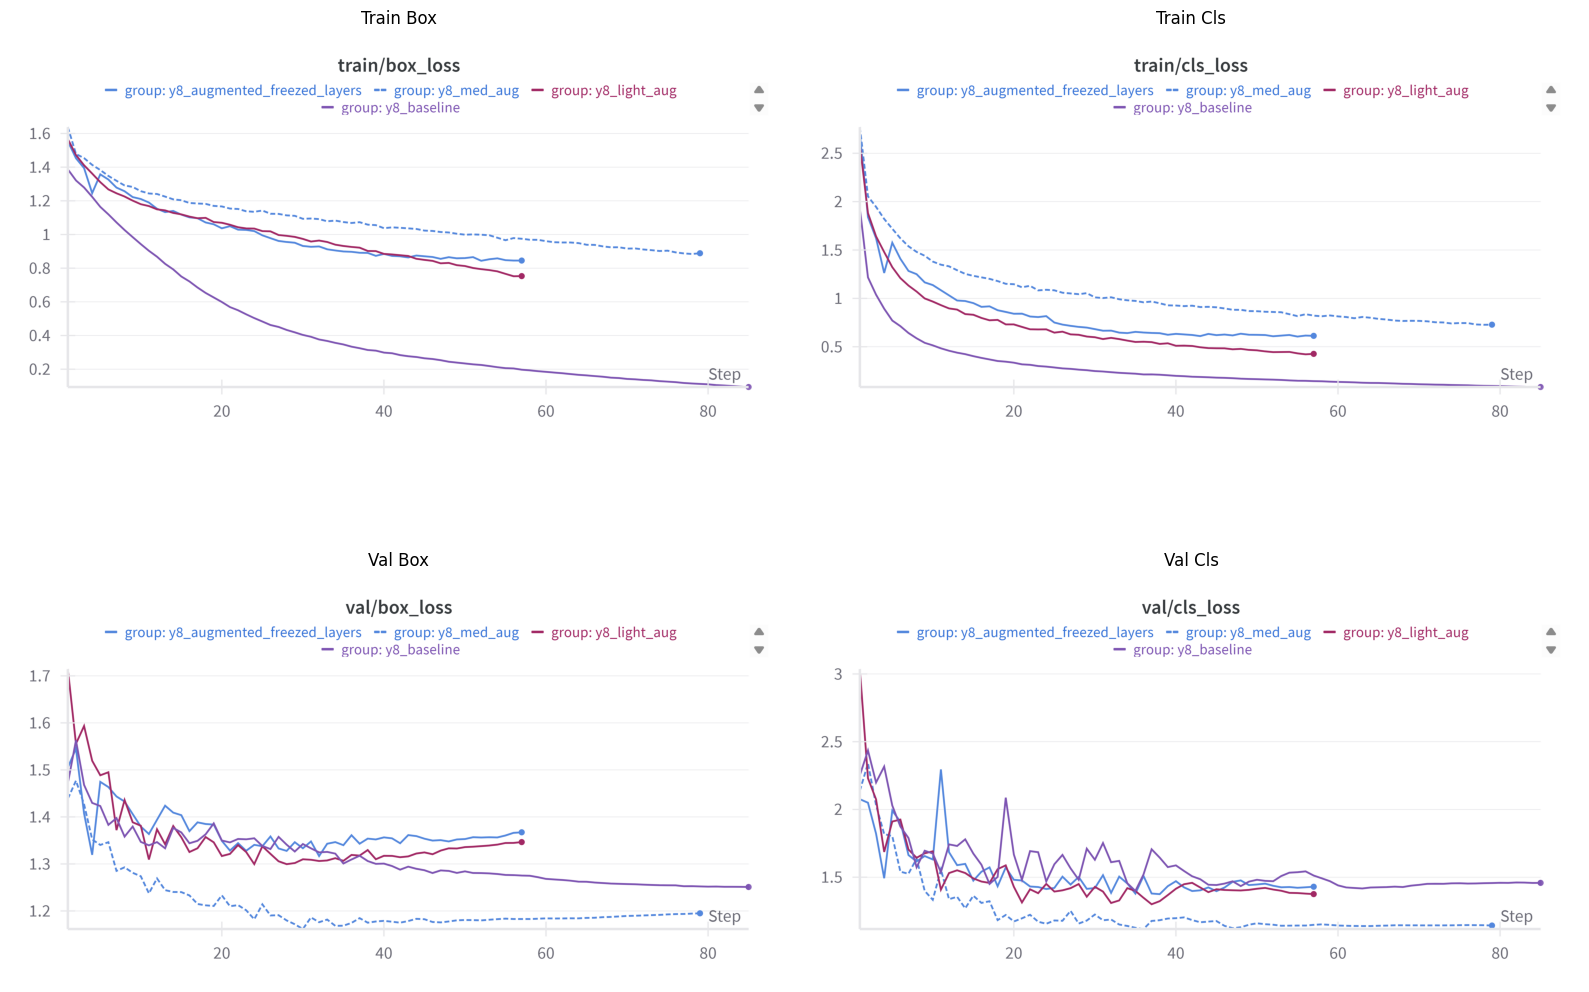

In [24]:
import os, matplotlib.pyplot as plt, matplotlib.image as mpimg
import numpy as np

ROOT  = "eval/single_stage/training/yolov8"   # adjust if needed
PAIRS = [("train_box.png", "train_cls.png"),
         ("val_box.png",   "val_cls.png")]

fig, axes = plt.subplots(2, 2, figsize=(16, 12)) 

for (left, right), row in zip(PAIRS, axes):
    for fname, ax in zip((left, right), row):
        path = os.path.join(ROOT, fname)
        ax.imshow(mpimg.imread(path))
        ax.set_title(fname[:-4].replace('_', ' ').title())
        ax.axis('off')

plt.tight_layout()
plt.show()


## MegaDetector-v6 – Transfer-learning baseline  

After exploring scratch-training with YOLOv8, we switched to **MegaDetector v6**, a pre-trained wildlife detector from Microsoft’s *pytorch-wildlife* library.  
The idea is to test whether transfer learning outperforms a from-scratch approach on our camera-trap data.

* **Setup**
  * Start from MD-v6 weights (pre-trained on the 4-million-image Wildlife dataset).  
  * Freeze the backbone for the first few epochs, then fine-tune end-to-end.  
  * Use the library’s built-in, moderate augmentations (flips, colour-jitter, light geometric)—no heavy synthetic transforms.

* **Plots below**  
  * **Left:** box-regression loss  • **Right:** classification loss   
  * The sharp early drop then smooth plateau shows the pre-trained backbone adapting quickly with minimal over-fitting—noticeably cleaner than the YOLOv8 scratch curves.

These curves suggest that leveraging MD-v6’s prior knowledge is a more efficient starting point for our pipeline.


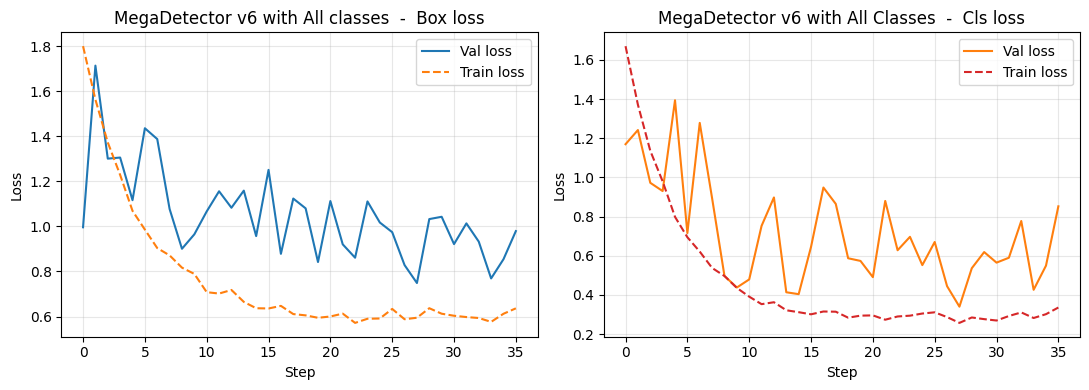

In [25]:
import pandas as pd


# --- file paths ---
BOX_CSV = "eval/single_stage/training/mdv6_allClasses/box_loss.csv"
CLS_CSV = "eval/single_stage/training/mdv6_allClasses/cls_loss.csv"

# --- read csvs ---
box_df = pd.read_csv(BOX_CSV)
cls_df = pd.read_csv(CLS_CSV)

# --- column names ---
VAL_COL   = "Val_loss"   if "Val_loss"   in box_df.columns else "Value"
TRAIN_COL = "Train_loss" if "Train_loss" in box_df.columns else None

# --- plot ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Box loss
axes[0].plot(box_df["Step"], box_df[VAL_COL], label="Val loss")
if TRAIN_COL:
    axes[0].plot(box_df["Step"], box_df[TRAIN_COL], linestyle="--", label="Train loss")
axes[0].set_title("MegaDetector v6 with All classes  -  Box loss")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].grid(alpha=0.3)
axes[0].legend()

# Cls loss
axes[1].plot(cls_df["Step"], cls_df[VAL_COL], label="Val loss", color="tab:orange")
if TRAIN_COL and TRAIN_COL in cls_df.columns:
    axes[1].plot(cls_df["Step"], cls_df[TRAIN_COL], linestyle="--", label="Train loss", color="tab:red")
axes[1].set_title("MegaDetector v6 with All Classes  -  Cls loss")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Loss")
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


## Detector-stage metrics – scratch vs. transfer learning  

**How do the models stack up?**  
Below we compare five detector variants on the held-out *camera-station* (**CIS**) and *cross-station* (**TRANS**) splits.  Each bar-plot gives the mean of the 15 species; the final chart shows how much F1 drops when we move from CIS to TRANS (domain-shift penalty).

| Run | Recipe | Short-hand |
|-----|--------|-----------|
| Baseline | YOLOv8, scratch, no aug | **Baseline** |
| Light Aug | YOLOv8 + light progressive aug | **Light Aug** |
| Med Aug   | YOLOv8 + medium aug | **Med Aug** |
| Med Aug Frozen | medium aug + backbone frozen initially | **Med Aug Frozen** |
| MD-v6 | MegaDetector-v6 transfer-learned | **MegaDetector v6** |

---

### Key take-aways

* **Augmentations help, but only up to a point**  
  * Going from *Baseline* → *Med Aug* gives +0.07 mAP and +0.05 F1 (CIS).  
  * Freezing the backbone (**Med Aug Frozen**) hurts TRANS recall; the network struggles to adapt once the layers are unfrozen.

* **MegaDetector-v6 wins on every metric**  
  * +0.06 F1 and +0.08 mAP over the best YOLOv8 scratch run on CIS.  
  * Highest precision and the smallest domain-shift penalty (only −0.16 F1).

* **Domain shift is still real**  
  * All YOLOv8 variants lose ≈ 0.24 F1 when jumping to unseen stations.  
  * MD-v6 halves that drop, thanks to the richer pre-training set.

* **Class-specific quirks (not shown)**  
  * Deer is absent in TRANS ⇒ bars omitted.  
  * Rare species (badger, rodent) remain challenging across the board; even transfer learning can’t fully rescue classes with < 150 training examples.

In short, transfer-learning from a wildlife-centric backbone delivers a sizable boost and better generalisation.  Scratch training benefits from clever augmentation, but plateaus quickly.


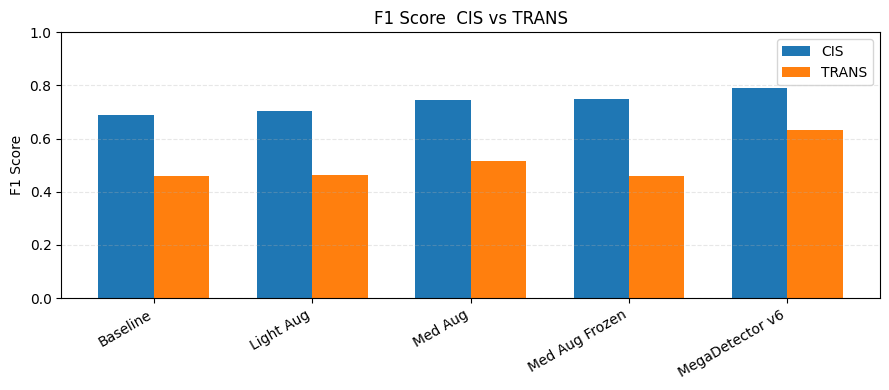

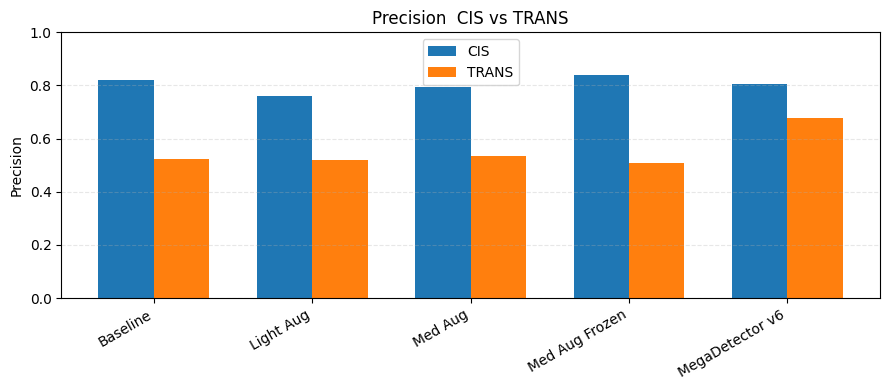

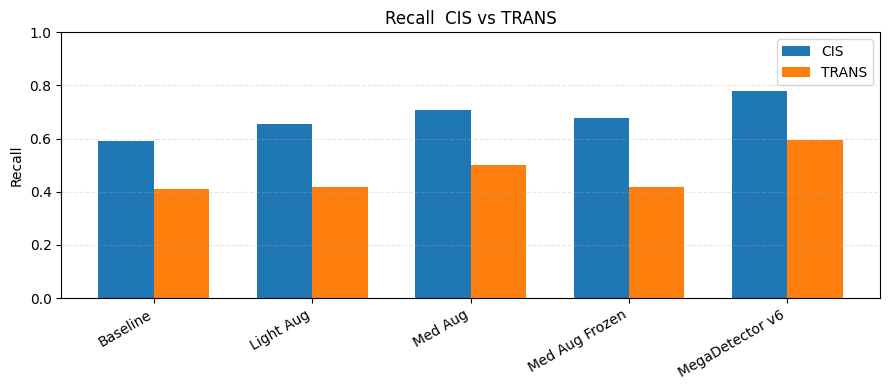

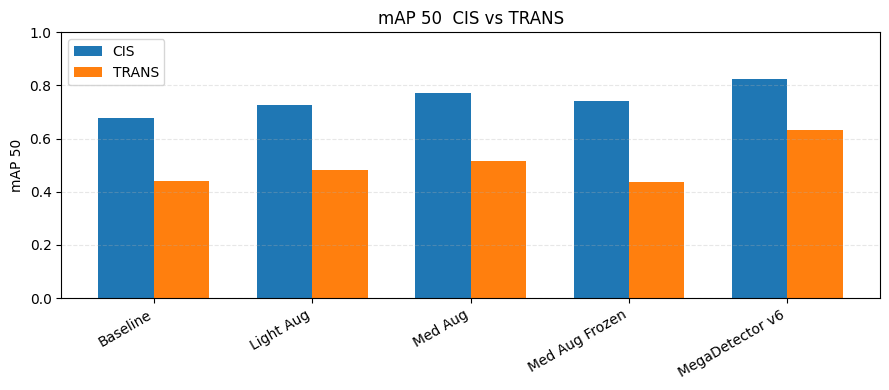

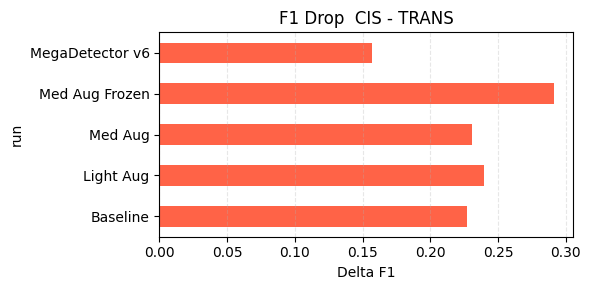

In [26]:


# 1)  Read CSV
CSV_PATH = "eval/single_stage/detailed_analysis.csv"
df = pd.read_csv(CSV_PATH)

# 2)  Friendly run names and drop the experimental run
LABELS = {
    "y8_baseline"                 : "Baseline",
    "y8_augmented_light"          : "Light Aug",
    "y8_augmented_2"              : "Med Aug",
    "y8_augmented_freezed_layers" : "Med Aug Frozen",
    "megadetectorv6"              : "MegaDetector v6",
}
df = df[df["model"] != "y8_augmented_1"]
df["run"] = df["model"].map(LABELS)

ORDER = ["Baseline", "Light Aug", "Med Aug", "Med Aug Frozen", "MegaDetector v6"]

# 3)  Keep only test splits
test_df = df[df["split"] == "test"].copy()

# 4)  Helper to draw CIS vs TRANS bars
def bar_pair(metric, nice, ylim=(0, 1)):
    cis   = (test_df[test_df["domain"] == "cis"]
             .set_index("run").reindex(ORDER)[metric])
    trans = (test_df[test_df["domain"] == "trans"]
             .set_index("run").reindex(ORDER)[metric])

    x = range(len(ORDER))
    width = 0.35
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar([i - width/2 for i in x], cis,   width=width, label="CIS")
    ax.bar([i + width/2 for i in x], trans, width=width, label="TRANS")

    ax.set_xticks(x)
    ax.set_xticklabels(ORDER, rotation=30, ha="right")
    ax.set_ylim(*ylim)
    ax.set_ylabel(nice)
    ax.set_title(f"{nice}  CIS vs TRANS")
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

bar_pair("F1",        "F1 Score")
bar_pair("precision", "Precision")
bar_pair("recall",    "Recall")
bar_pair("mAP50",     "mAP 50")

# 5)  Domain-shift drop (F1)
delta = (test_df.pivot(index="run", columns="domain", values="F1")
                .reindex(ORDER)
                .assign(drop=lambda d: d["cis"] - d["trans"])["drop"])

delta.plot(kind="barh", color="tomato", figsize=(6, 3))
plt.title("F1 Drop  CIS - TRANS")
plt.xlabel("Delta F1")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## Confusion-matrix review – where the models still get it wrong

We looked at CIS and TRANS confusion matrices for five detector versions:

| Model | Training recipe |
|-------|-----------------|
| YOLOv8 **Baseline** | scratch, no aug |
| YOLOv8 **Light Aug** | light progressive aug |
| YOLOv8 **Med Aug** | medium aug |
| YOLOv8 **Med Aug + Frozen** | medium aug, backbone frozen at start |
| **MegaDetector v6** | transfer-learned |


---

### 1  Rare species are still hard  
* **Badger** (6 training photos) and **deer** (~30) have very few examples.  
  * On CIS they sometimes hit 0.7–0.8 recall, but on TRANS they drop fast.  
  * Deer is often predicted as *coyote* or *dog*; badger as *rodent* or *squirrel*.

### 2  Transfer learning cleans up the diagonal  
* MegaDetector-v6 keeps the darkest (best) diagonal cells.  
  * **Rabbit** recall climbs from about 0.46 (YOLOv8 baseline, TRANS-test) to > 0.75.  
  * Small, busy classes like **rodent** and **squirrel** gain 10–15 pp in precision.

### 3  Augmentation helps but can’t hide the station gap  
* Moving from Baseline → Light → Medium aug reduces false positives—especially vs. *bird* and *cat*.  
* Even so, on TRANS we still see swaps such as **dog → coyote** or **bobcat → squirrel**.

### 4  Freezing the backbone hurts rare classes  
* The “Med Aug + Frozen” run shows weaker diagonals for the small classes on TRANS; once the backbone is unfrozen it never quite catches up.  
  * **Skunk** recall, for example, falls below 0.3 (vs. > 0.6 for the fully-trainable Med Aug model).


In [27]:
from IPython.display import HTML, display
import os, glob, re

CM_ROOT = "eval/single_stage"  

LABEL = {
    "megadetectorv6"              : "MegaDetector-v6",
    "y8_baseline"                 : "Y8 Baseline",
    "y8_augmented_light"          : "Y8 Light Aug",
    "y8_augmented_2"              : "Y8 Med Aug",
    "y8_augmented_freezed_layers" : "Y8 Med Aug + Frozen",
}

cells = []
for path in sorted(glob.glob(os.path.join(CM_ROOT, "*_cm.png"))):
    if "y8_augmented_1" in path:
        continue
    m = re.match(r"(.+?)_(cis|trans)_(val|test)_cm.png", os.path.basename(path))
    if not m:
        continue
    model, dom, split = m.groups()
    title = f"{LABEL.get(model, model)} — {dom.upper()} {split.upper()}"
    cells.append(f"<td style='text-align:center'>"
                 f"<img src='{path}' width='600'><br>{title}</td>")

# assemble rows: 2 cells per row
rows = ["<tr>" + "".join(cells[i:i+2]) + "</tr>" for i in range(0, len(cells), 2)]
html = "<table>" + "".join(rows) + "</table>"
display(HTML(html))


MegaDetector-v6 — CIS TEST,MegaDetector-v6 — CIS VAL
MegaDetector-v6 — TRANS TEST,MegaDetector-v6 — TRANS VAL
Y8 Med Aug — CIS TEST,Y8 Med Aug — CIS VAL
Y8 Med Aug — TRANS TEST,Y8 Med Aug — TRANS VAL
Y8 Med Aug + Frozen — CIS TEST,Y8 Med Aug + Frozen — CIS VAL
Y8 Med Aug + Frozen — TRANS TEST,Y8 Med Aug + Frozen — TRANS VAL
Y8 Light Aug — CIS TEST,Y8 Light Aug — CIS VAL
Y8 Light Aug — TRANS TEST,Y8 Light Aug — TRANS VAL
Y8 Baseline — CIS TEST,Y8 Baseline — CIS VAL
Y8 Baseline — TRANS TEST,Y8 Baseline — TRANS VAL


## Two-stage pipeline – stage 1 detector (MegaDetector-v6, 2 classes)

For the final system we switched to a two-stage set-up:

1. **Stage 1 – object detector**  
   *Detect anything of interest and crop it out.*
2. **Stage 2 – image classifier**  
   *Take the crops and decide which species they contain.*

This cell shows the training curves for Stage 1.

### How the detector is configured  

* **Base model** MegaDetector-v6, already trained on millions of camera-trap images.  
* **Class collapse** The original 15 wildlife labels are merged into a single **animal** class; **car** is kept as **vehicle**.  
  * Rationale: a detector that only needs to answer “animal, vehicle, or background?” can concentrate on recall.  
  * All species-level fine detail is left to Stage 2, which sees the tight crops.
* **Training details**
  * Backbone frozen for the first few epochs, then unfrozen and fine-tuned end-to-end.  
  * Built-in MegaDetector augmentations (flips, colour jitter, light geometric) only—no heavy synthetic transforms.

### Reading the curves  

| Panel | What to notice |
|-------|----------------|
| **Box loss** (left) | Training loss drops fast and levels out < 0.1. Validation loss is noisier but follows the same downward trend. |
| **Cls loss** (right) | Once the backbone is unfrozen, the classification loss slips below 0.15 and stays there. Spikes in the validation curve correspond to frames with only background objects. |

The overall shape confirms that the two-class formulation is an easier learning problem: the model locks onto “anything alive” early, giving us high-recall proposals to pass to the species classifier.


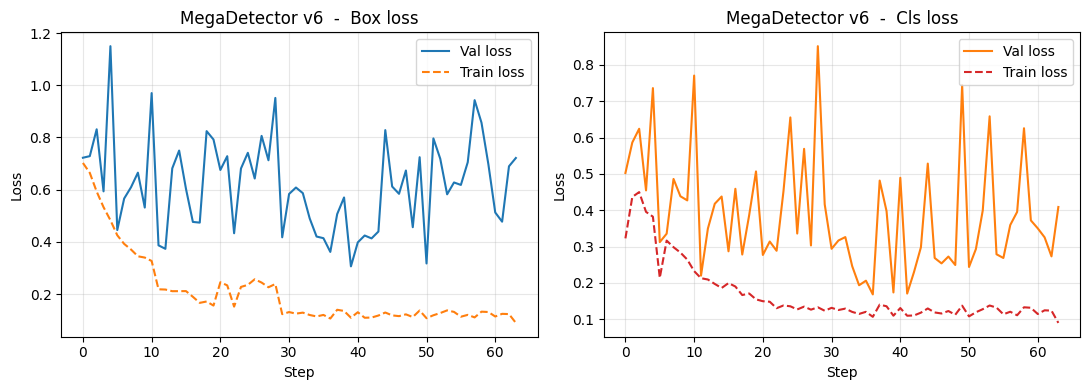

In [28]:


# --- file paths ---
BOX_CSV = "eval/detector_stage/training/mdv6/box_loss.csv"
CLS_CSV = "eval/detector_stage/training/mdv6/cls_loss.csv"

# --- read csvs ---
box_df = pd.read_csv(BOX_CSV)
cls_df = pd.read_csv(CLS_CSV)

# --- column names ---
VAL_COL   = "Val_loss"   if "Val_loss"   in box_df.columns else "Value"
TRAIN_COL = "Train_loss" if "Train_loss" in box_df.columns else None

# --- plot ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Box loss
axes[0].plot(box_df["Step"], box_df[VAL_COL], label="Val loss")
if TRAIN_COL:
    axes[0].plot(box_df["Step"], box_df[TRAIN_COL], linestyle="--", label="Train loss")
axes[0].set_title("MegaDetector v6  -  Box loss")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].grid(alpha=0.3)
axes[0].legend()

# Cls loss
axes[1].plot(cls_df["Step"], cls_df[VAL_COL], label="Val loss", color="tab:orange")
if TRAIN_COL and TRAIN_COL in cls_df.columns:
    axes[1].plot(cls_df["Step"], cls_df[TRAIN_COL], linestyle="--", label="Train loss", color="tab:red")
axes[1].set_title("MegaDetector v6  -  Cls loss")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Loss")
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


### Two-class detector – test-set results

The plots below summarise the performance of the 2-class MegaDetector-v6 on the held-out CIS and TRANS test splits.


**What the plots show**

* **Top row** – F1 and mAP bars are almost identical for CIS and TRANS, indicating that the detector generalises well to unseen camera stations.
* **Bottom-left** – Precision vs. recall points sit in the upper-right corner; the detector rarely misses an animal or vehicle and keeps false positives low.
* **Bottom-right** – The CIS → TRANS drop is only ~1.6 percentage points. Compared with the 15-class YOLOv8 runs earlier in the notebook, this is a much smaller shift, confirming that the simpler two-class task is more robust.

In short, the first-stage detector meets its goal: reliably flag every animal (or vehicle) with minimal performance loss when moving to new locations.


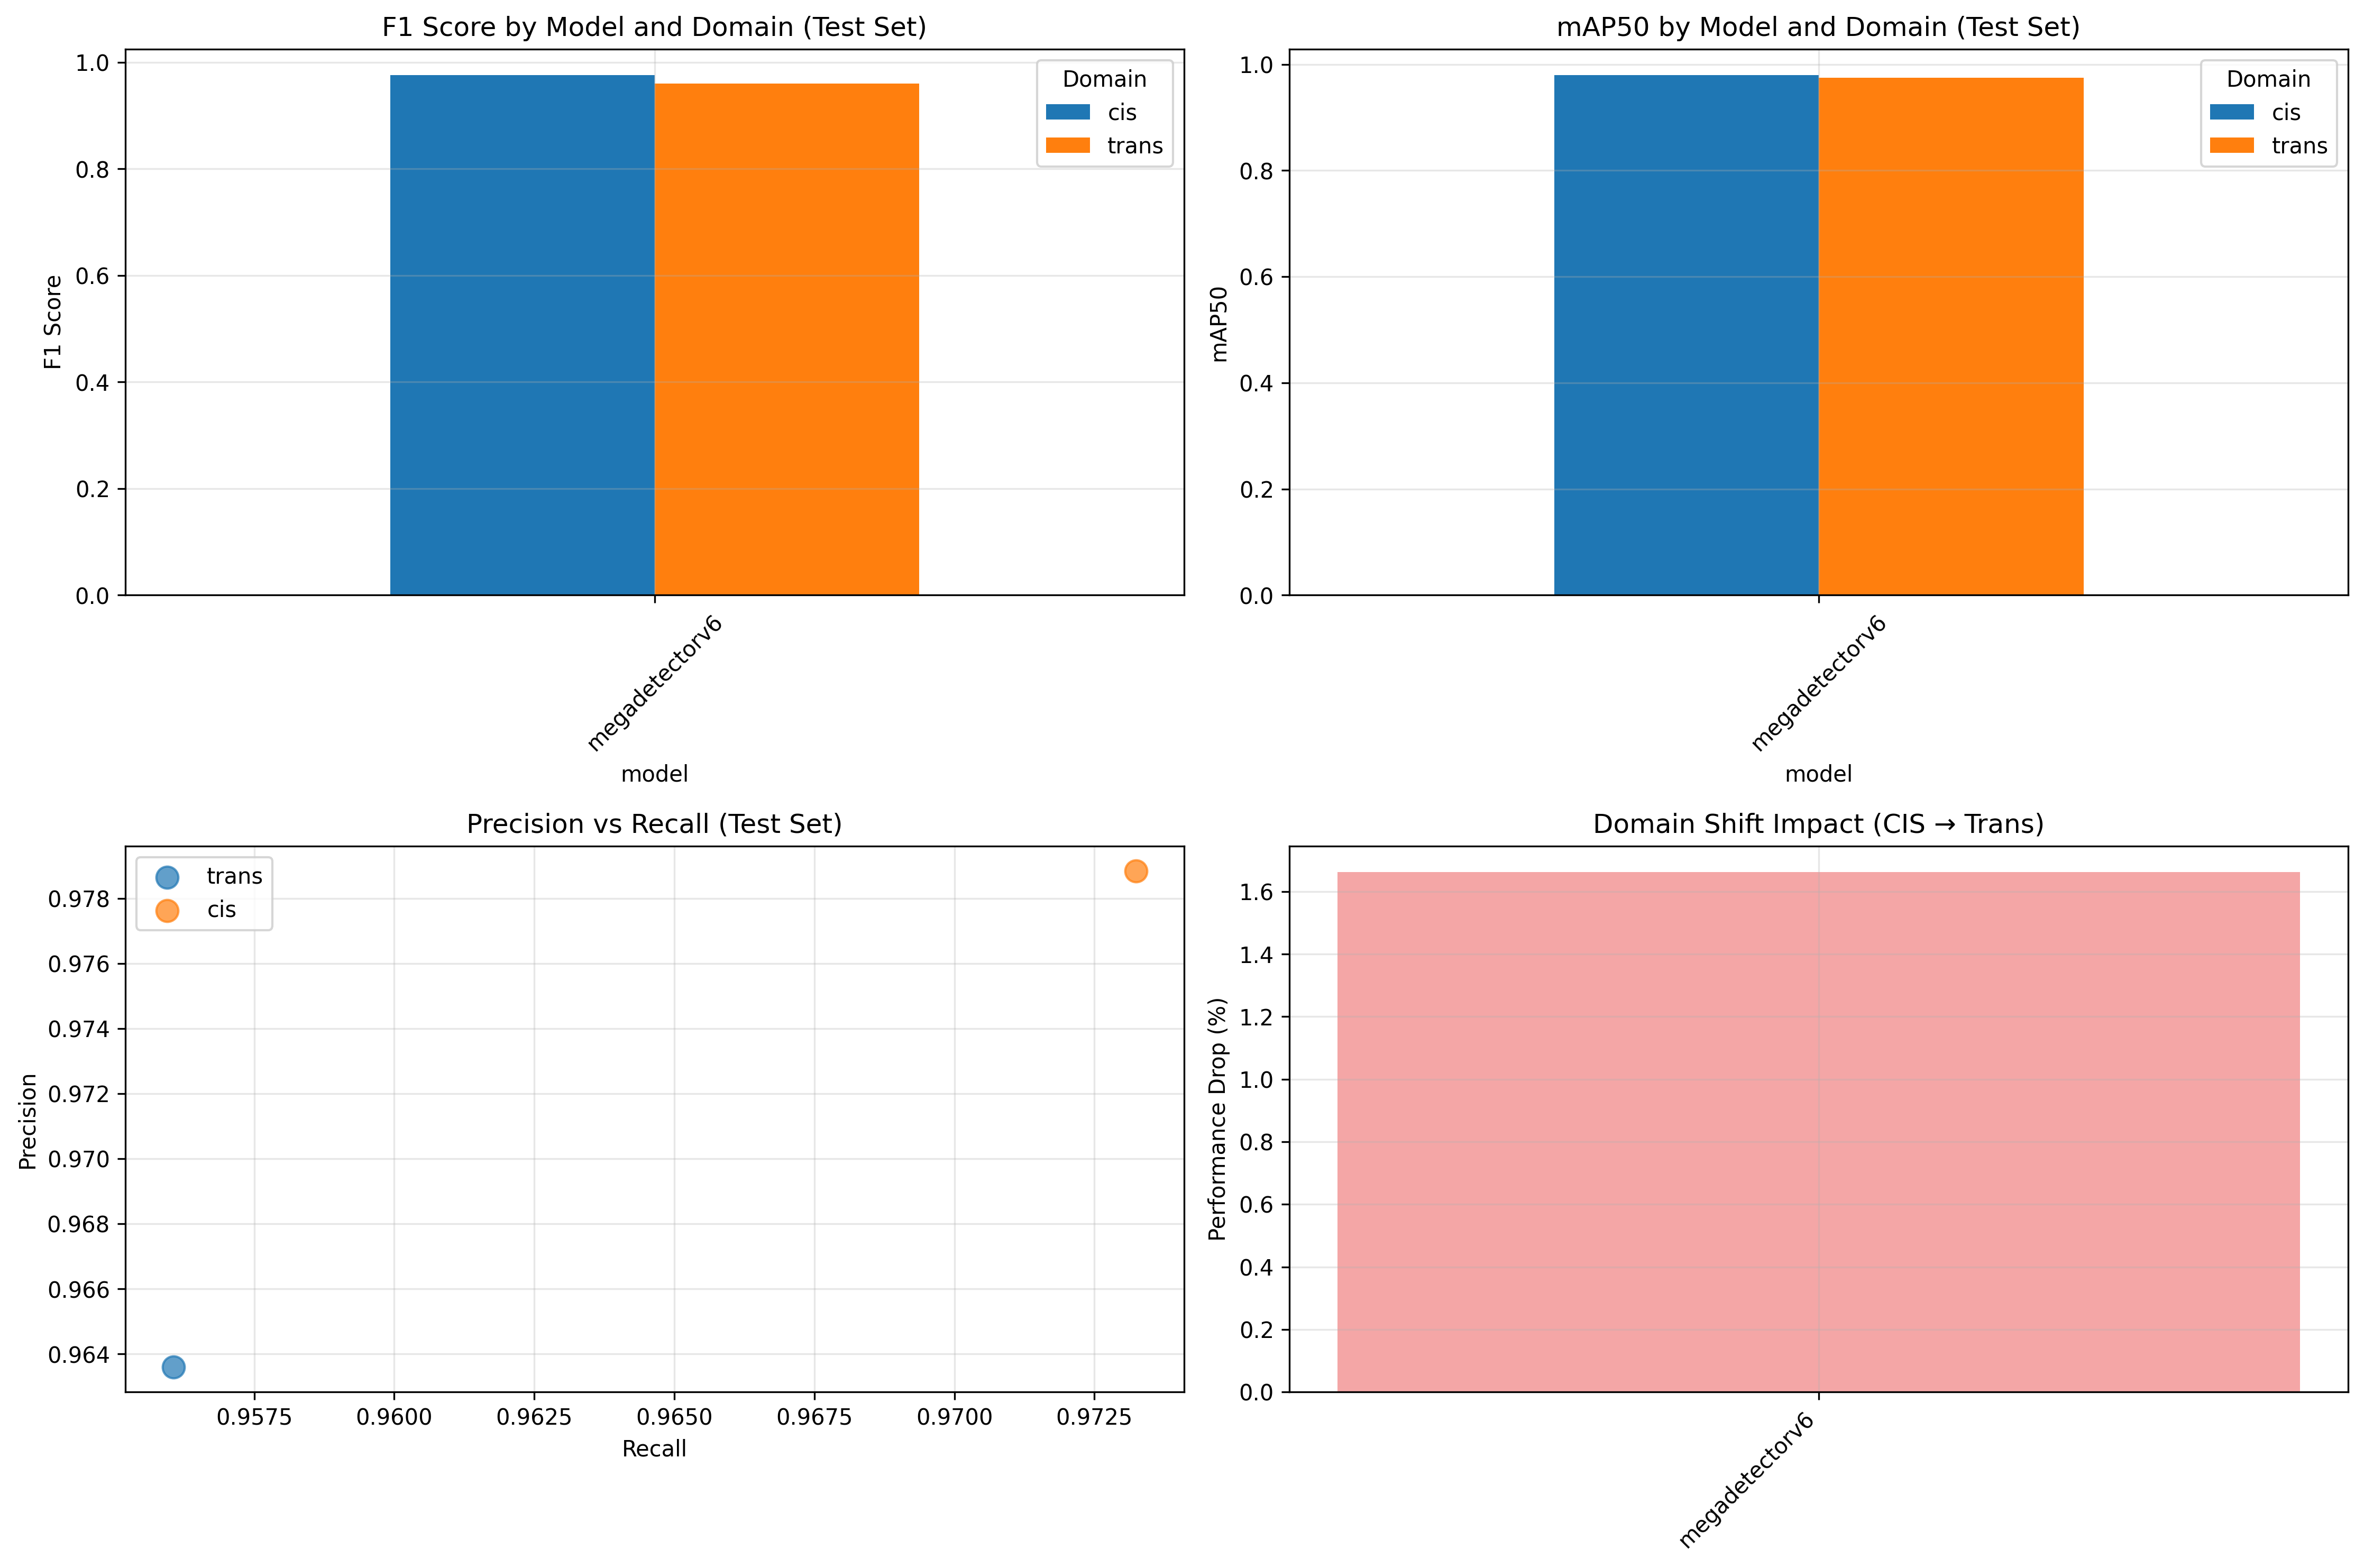

In [29]:
from IPython.display import Image, display

# path to the PNG you want to show
display(Image("eval/detector_stage/evaluation_summary.png", width=1200)) 


### Two-class detector – confusion-matrix snapshot

Below are the CIS / TRANS confusion matrices for the 2-class MegaDetector-v6 (animal vs vehicle).


Key points  

* Misclassifications are almost entirely **animal predicted as vehicle**; the reverse mistake is negligible.  
* The TRANS splits show a small drop (≈ 2–4 pp) in the animal diagonal, matching the metrics panel earlier.  
* No other off-diagonal activity appears, confirming that background patches are largely ignored.

**Threshold choice**  

To maximise recall we set a lower confidence threshold at this stage—any patch that crosses it is passed to the species-level classifier.  
If the classifier then returns a low confidence score, the patch is treated as background and discarded.  
This two-tier approach keeps false negatives low while letting the second stage do the fine filtering.


In [30]:
from IPython.display import HTML

IMG_DIR = "eval/detector_stage"

pngs = [
    ("megadetectorv6_cis_val_cm.png",   "MegaDetector-v6 • CIS VAL"),
    ("megadetectorv6_cis_test_cm.png",  "MegaDetector-v6 • CIS TEST"),
    ("megadetectorv6_trans_val_cm.png", "MegaDetector-v6 • TRANS VAL"),
    ("megadetectorv6_trans_test_cm.png","MegaDetector-v6 • TRANS TEST"),
]

rows = []
for i in range(0, len(pngs), 2):
    cells = [
        f"<td style='text-align:center'>"
        f"<img src='{os.path.join(IMG_DIR, fname)}' width='600'><br>{title}</td>"
        for fname, title in pngs[i:i+2]
    ]
    rows.append("<tr>" + "".join(cells) + "</tr>")

display(HTML("<table>" + "".join(rows) + "</table>"))


MegaDetector-v6 • CIS VAL,MegaDetector-v6 • CIS TEST
MegaDetector-v6 • TRANS VAL,MegaDetector-v6 • TRANS TEST


## Stage-2 species classifier – design choices and training behaviour

### Why these two backbones?

| Backbone | Short reason |
|-----------|--------------|
| **EfficientNet-V2-S + CBAM** | Compact CNN with strong parameter-efficiency; three **CBAM** attention blocks were added to let the network focus on fine animal textures (ears, tails) without a large compute penalty. CBAM’s channel-plus-spatial attention has been shown to give consistent ImageNet gains with negligible overhead |
| **ConvNeXt-Small (class-aware variant)** | A modern ResNet-style CNN that borrows ideas from Vision Transformers: larger 7 × 7 depthwise kernels, inverted bottlenecks and LayerNorm, yet keeps full convolutional inductive bias |

Both models output 14 wildlife classes (the **vehicle** class was already handled by the detector).

### Tackling class imbalance  

* **Class-Balanced Focal Loss** – we used the formulation from Cui et al. (2019), which re-weights the focal term by the *effective number* of samples per class.
* **Weighted sampler** – minority classes are over-sampled on the fly, synchronised with the CB-Focal weighting.

### Augmentation policy  

Two `torchvision` pipelines were used:

* **train** – mild crops, flips, small colour/rotation jitter, and random erasing.  
* **tail classes** – applied only on under-represented classes; uses a wider crop scale, stronger colour jitter, 25° rotations and perspective warp to wrestle overfitting on the tiny classes.

Neither pipeline adds heavy synthetic clutter; the aim is to preserve fine animal details for the classifier while still giving some pose and lighting variation.

### What do the curves say?  

The figure above shows loss and accuracy for both backbones:

* **EfficientNet-V2-S** reaches a stable validation top-1 of ~85 % and top-3 of ~93 % after 50 epochs. The gap between train and val loss stays small, suggesting the mild augmentations were enough to curb over-fit.  
* **ConvNeXt-Small (class-aware)** converges faster (≈ 20 epochs) and plateaus around 88 % top-1 / 95 % top-3. The flatter validation loss after epoch 10 matches the expectation that ConvNeXt’s wider kernels capture larger animal parts early on.

Overall, the ConvNeXt classifier provided the best trade-off between accuracy and training time, while the EfficientNet-V2 variant served as a lighter back-up with similar top-3 coverage.


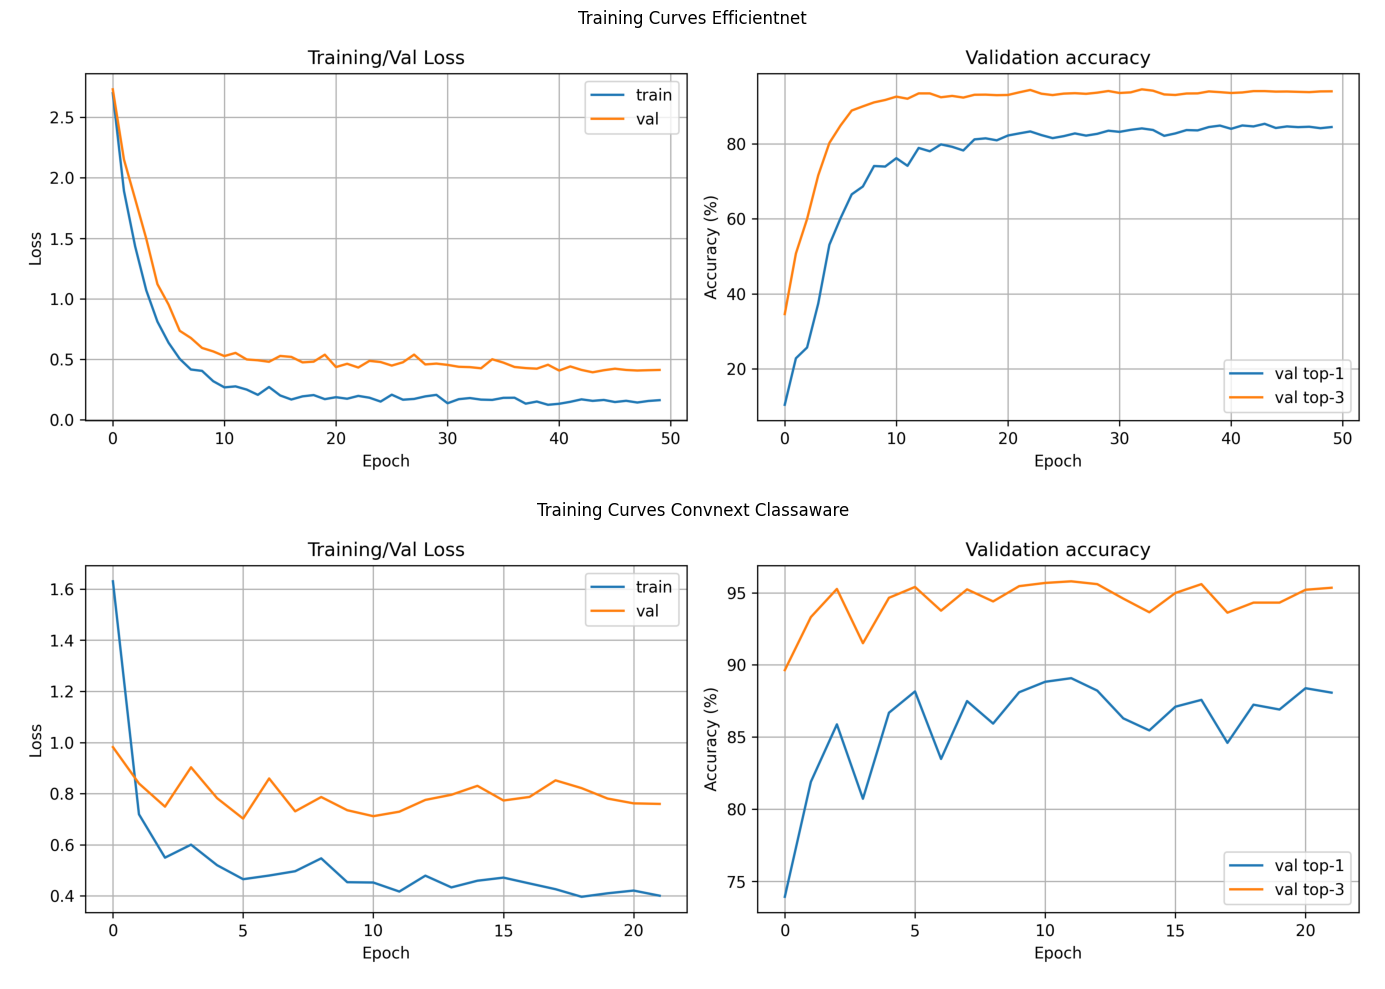

In [31]:


ROOT = "eval/classifier_stage"
pngs = [
    "training_curves_efficientnet.png",
    "training_curves_convnext_classaware.png",
]

fig, axes = plt.subplots(len(pngs), 1, figsize=(16, 10))

for ax, fname in zip(axes, pngs):
    img = mpimg.imread(os.path.join(ROOT, fname))
    ax.imshow(img)
    ax.set_title(fname.replace('_', ' ').replace('.png', '').title())
    ax.axis('off')

plt.tight_layout()
plt.show()


### Classifier test-set results – ConvNeXt vs EfficientNet-V2

The figure compares the two class-aware backbones on CIS and TRANS test crops.

Observations
* **ConvNeXt-Small leads across the board.** Gains are modest on CIS (+3–4 pp) but widen on TRANS (+6–8 pp), matching its larger receptive field and stronger regularisation.
* **Domain shift cost is ~7 pp** in accuracy for ConvNeXt, ~10 pp for EfficientNet-V2. This mirrors what we saw at the detector stage: the TRANS images are consistently harder, but the newer backbone handles the change better.
* Precision and recall stay balanced for both models, suggesting that the CB-Focal loss plus weighted sampling kept true-positive and false-positive rates in check—even for the long-tail species.

Bottom line: ConvNeXt-Small with class-balanced focal loss is the stronger choice for stage-2 classification, especially when the pipeline is deployed on new camera stations.


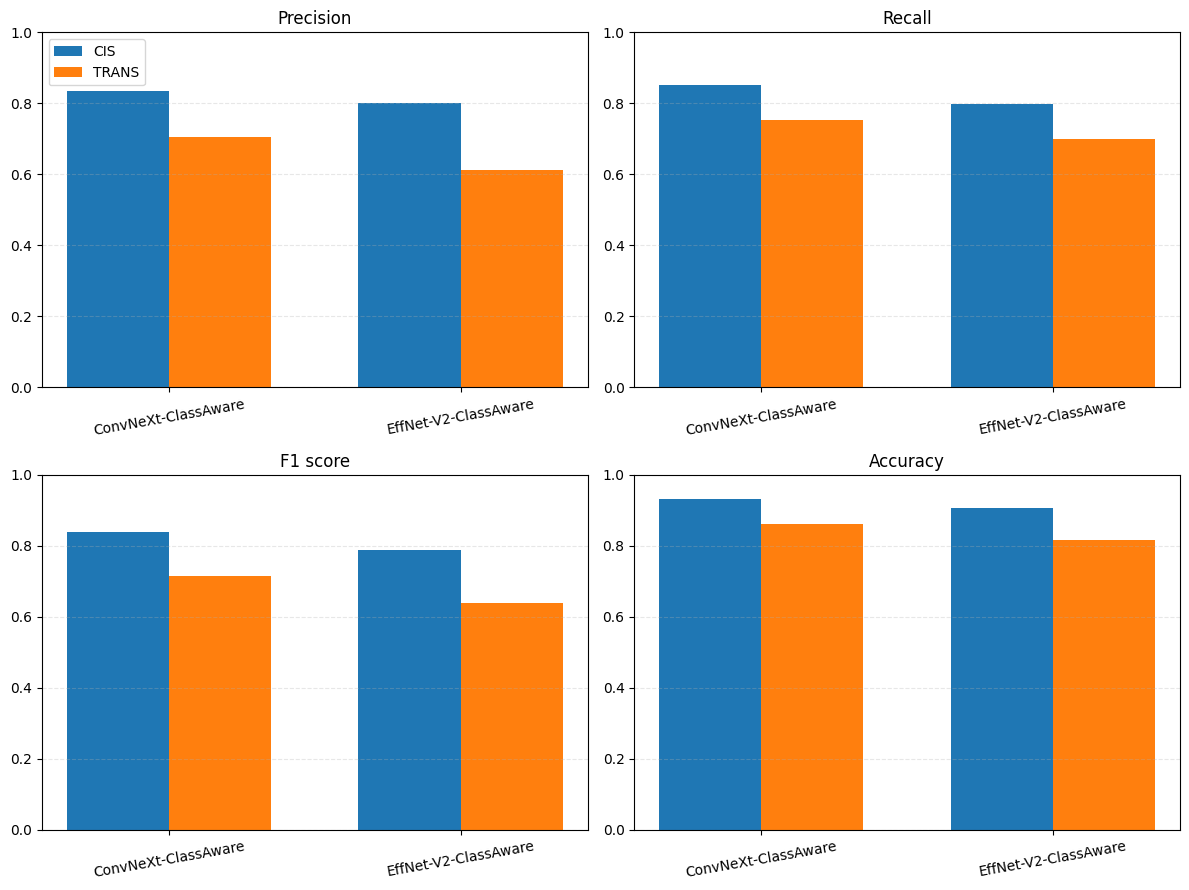

In [32]:


CSV = "eval/classifier_stage/summary_metrics.csv"

df = pd.read_csv(CSV)
df = df[df["model"].isin(["convnext_classaware",
                          "efficientnet_v2_s_classaware"])]
test = df[df["split"] == "test"]

models  = ["convnext_classaware", "efficientnet_v2_s_classaware"]
labels  = ["ConvNeXt-ClassAware", "EffNet-V2-ClassAware"]

metrics = [("precision", "Precision"),
           ("recall",    "Recall"),
           ("F1",        "F1 score"),
           ("acc",       "Accuracy")]

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.ravel()
width = 0.35
x     = range(len(models))

for ax, (m, ttl) in zip(axes, metrics):
    cis   = (test[test.domain == "cis"]
             .set_index("model").loc[models][m])
    trans = (test[test.domain == "trans"]
             .set_index("model").loc[models][m])

    ax.bar([i - width/2 for i in x], cis,   width, label="CIS")
    ax.bar([i + width/2 for i in x], trans, width, label="TRANS")
    ax.set_title(ttl)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=10)
    ax.set_ylim(0, 1); ax.grid(axis="y", ls="--", alpha=0.3)

axes[0].legend(loc="upper left")
plt.tight_layout()
plt.show()


### Species-level confusion matrices – what they tell us

Below are the CIS / TRANS confusion matrices for the two class-aware classifiers.
They confirm the headline numbers from the bar charts:

* **On familiar (CIS) stations** both backbones are very reliable.  Most species sit above 0.85 on the diagonal; several (opossum, skunk, bobcat, squirrel) are routinely > 0.90.
* **On unseen (TRANS) stations** the diagonal lightens a little but stays serviceable; accuracy falls by ~7 pp for ConvNeXt and ~10 pp for EfficientNet-V2.

Common patterns
* **Rodent** (tiny subject, cluttered background) often leaks into *rabbit* or *squirrel* on TRANS splits.
* **Badger** is the hardest class everywhere – as expected with only six training images.  Even the better ConvNeXt run lands at ≈ 0.33 recall in the hardest setting.
* **Deer**, another tail class, actually holds up: after merging the detector’s generous crops with class-balanced focal loss the classifier reaches about 0.55–0.60 recall on TRANS, a big step up from the scratch-trained YOLO detector.

In short, the two-stage pipeline is rock-solid on well-sampled species and still usable on new camera stations; the remaining blind spot is the badly under-represented badger class, where more data would clearly help.


In [33]:


IMG_DIR = "eval/classifier_stage"

# nice names
LABEL = {
    "convnext_classaware"            : "ConvNeXt-ClassAware",
    "efficientnet_v2_s_classaware"   : "EffNet-V2-ClassAware",
}

# gather PNGs, keep only the two models above
pngs = []
for path in sorted(glob.glob(os.path.join(IMG_DIR, "*_cm.png"))):
    fname  = os.path.basename(path)
    m = re.match(r"(convnext_classaware|efficientnet_v2_s_classaware)_(cis|trans)_(val|test)_cm\.png", fname)
    if not m:
        continue
    model, dom, split = m.groups()
    title = f"{LABEL[model]} • {dom.upper()} {split.upper()}"
    pngs.append((fname, title))

# build 2-per-row html
rows = []
for i in range(0, len(pngs), 2):
    cells = [
        f"<td style='text-align:center'>"
        f"<img src='{os.path.join(IMG_DIR,f)}' width='600'><br>{t}</td>"
        for f, t in pngs[i:i+2]
    ]
    rows.append("<tr>" + "".join(cells) + "</tr>")

display(HTML("<table>" + "".join(rows) + "</table>"))


ConvNeXt-ClassAware • CIS TEST,ConvNeXt-ClassAware • CIS VAL
ConvNeXt-ClassAware • TRANS TEST,ConvNeXt-ClassAware • TRANS VAL
EffNet-V2-ClassAware • CIS TEST,EffNet-V2-ClassAware • CIS VAL
EffNet-V2-ClassAware • TRANS TEST,EffNet-V2-ClassAware • TRANS VAL


### End-to-end pipeline results — find everything first, label second

Our production chain couples **MegaDetector-v6** (2-class detector) ➜ **ConvNeXt-ClassAware** (14-class classifier) with carefully-tuned confidence gates on **both** stages.

| Stage | What happens |
|-------|--------------|
| **1. Detector**<br>• binary (*animal* vs *vehicle*)<br>• confidence ≈ **0.35**<br>• crops every hit | *Broad bucket first* – simpler task generalises better than 14-way detection.<br>Low threshold favours **recall**; reviewing a few extra crops is cheaper than missing a rare species. |
| **2. Classifier**<br>• **ConvNeXt-Small** <br>• Class-Balanced Focal Loss (Cui et al., 2019)<br>• Weighted sampler for tail species<br>• reject crop if **p < 0.55** | ConvNeXt keeps ViT-style 7 × 7 kernels but runs as an efficient CNN → great accuracy on modest hardware.<br>CB-Focal + sampling counters the long-tail (e.g. only 6 × *badger* vs 3 k × *opossum*).<br>The rejection gate stops low-confidence crops from diluting precision. |

---

#### Fine-tuning on real detector crops  
After the clean supervised run, we **fine-tuned on the detector’s own (imperfect) crops**.  
This lightweight “noisy-student” pass teaches the classifier to cope with off-centre or oversized boxes it will see in practice.

---

### What the plots show

| Plot block | Take-away |
|------------|-----------|
| **Overall Accuracy / Weighted F1** | 97 – 98 % on seen (CIS) stations; ~94 % on unseen (TRANS). The pipeline holds up even with very different backgrounds. |
| **Per-class Accuracy** | *Badger* (few shots) and *rodent* (tiny targets) remain hardest. Every other species stays above 90 % (CIS) and 80 % (TRANS). |

---

**Bottom line**  
Letting the detector cast a wide net, then a focal-loss ConvNeXt clean up the details, keeps **recall high for rare species without torpedoing precision** — and does so almost as well on unseen camera stations.


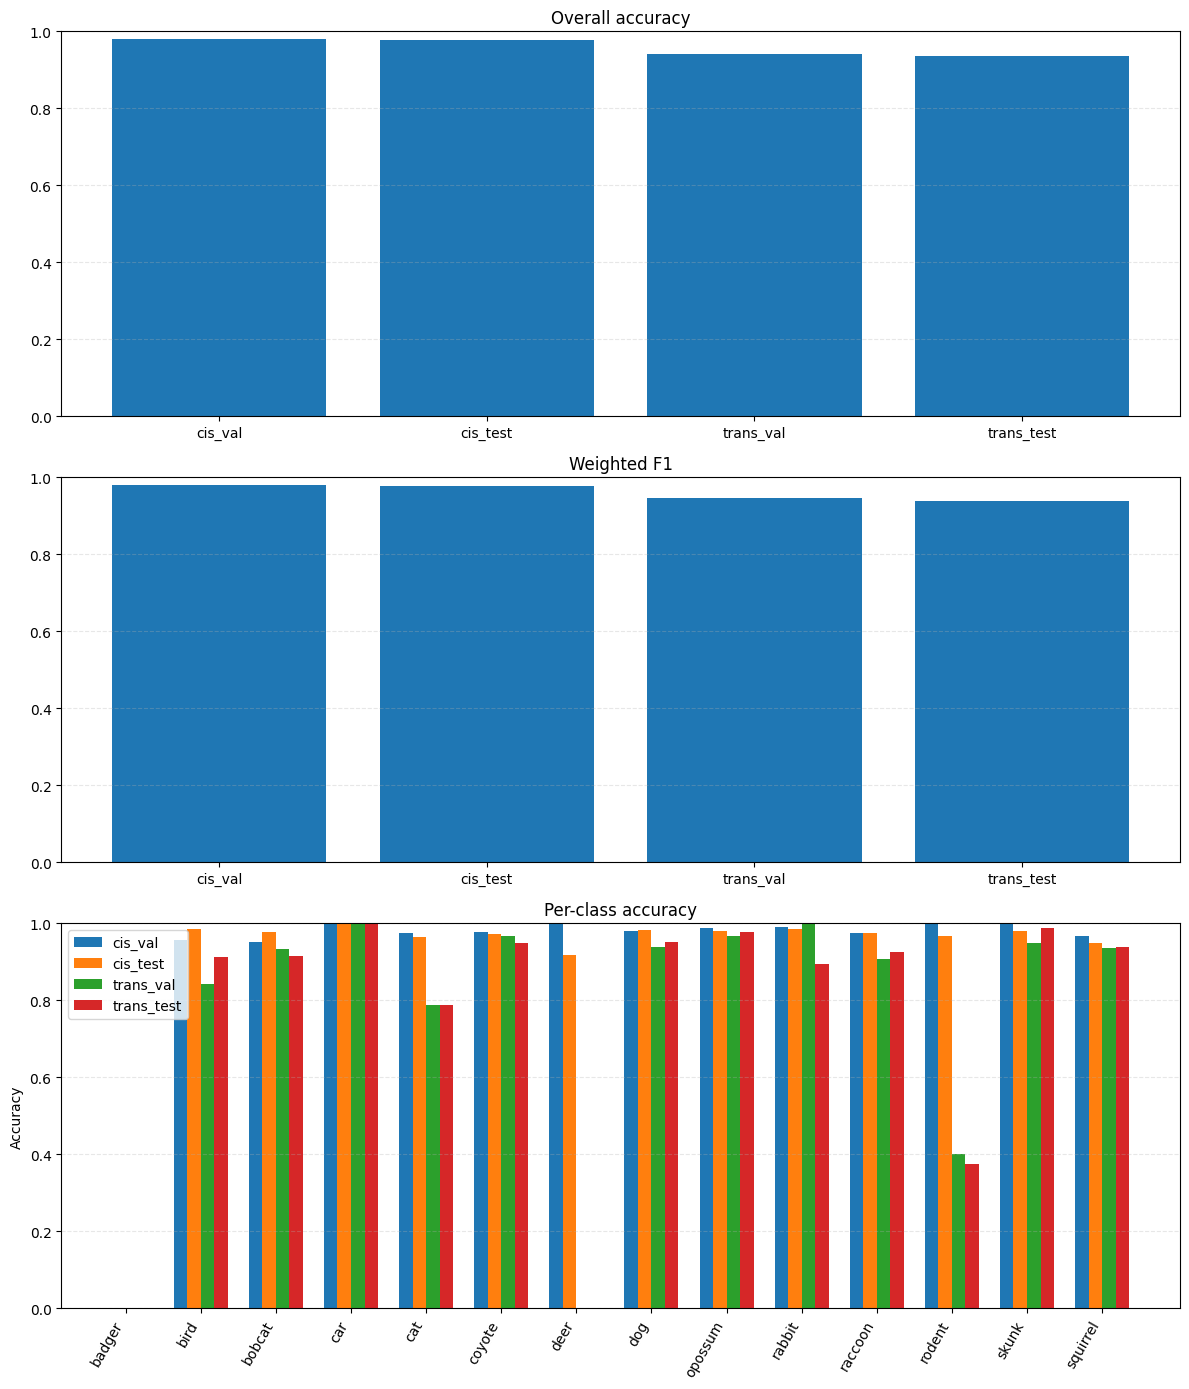

In [34]:


DIR   = "eval/pipeline_results/eval_reports"
files = glob.glob(os.path.join(DIR, "*_comprehensive_metrics.csv"))

df = pd.concat(
    pd.read_csv(f).assign(split=os.path.basename(f).replace("_comprehensive_metrics.csv",""))
    for f in files
)

order  = ["cis_val", "cis_test", "trans_val", "trans_test"]
df     = df.set_index("split").loc[order]

# ---------- overall & weighted plots ----------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))

ax1.bar(df.index, df["overall_accuracy"])
ax1.set_ylim(0,1); ax1.set_title("Overall accuracy"); ax1.grid(axis="y", ls="--", alpha=0.3)

ax2.bar(df.index, df["weighted_f1"])
ax2.set_ylim(0,1); ax2.set_title("Weighted F1"); ax2.grid(axis="y", ls="--", alpha=0.3)

# ---------- per-class accuracy (grouped bars) ----------
class_cols = [c for c in df.columns if c.endswith("_accuracy") and c not in ("overall_accuracy","weighted_f1")]
classes    = [c.replace("_accuracy","") for c in class_cols]

x      = np.arange(len(classes))
width  = 0.18

for i, split in enumerate(df.index):
    vals = df.loc[split, class_cols].values
    ax3.bar(x + i*width, vals, width, label=split)

ax3.set_xticks(x + width*1.5)
ax3.set_xticklabels(classes, rotation=60, ha="right")
ax3.set_ylim(0,1)
ax3.set_ylabel("Accuracy")
ax3.set_title("Per-class accuracy")
ax3.grid(axis="y", ls="--", alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()


### Per-class metrics – what stands out?

- **CIS splits (‘seen’ stations) are squeaky-clean.**  
  Precision, recall, and F1 all sit in the mid-90s or higher for every class on both *cis_val* and *cis_test*.

- **TRANS splits widen the gap.**  
  Most species still land in the high-80s/low-90s, but the spread between classes becomes obvious once the cameras change.

- **Tail classes take the biggest hit.**  
  *Rodent* (tiny targets) and *badger* (only six training images) lose the most ground on *trans_test*—precision drops to single digits, and F1 sinks below 0.2.

- **Head classes remain rock-solid.**  
  Common species such as *car*, *opossum*, *raccoon*, and *dog* keep F1 above 0.9 even on unseen stations.

- **Precision slips before recall.**  
  For several species (*rabbit* in *trans_val* is the clearest example) the detector still finds the animal, but the classifier’s confidence falls—leading to lower precision while recall stays high.

**Take-away:**  
The detector-then-classifier pipeline generalises well for well-represented species, but rare or very small animals still need either more data. Under domain shift, precision is the first metric to sag, so conservative confidence thresholds—and perhaps per-class tuning—remain essential.


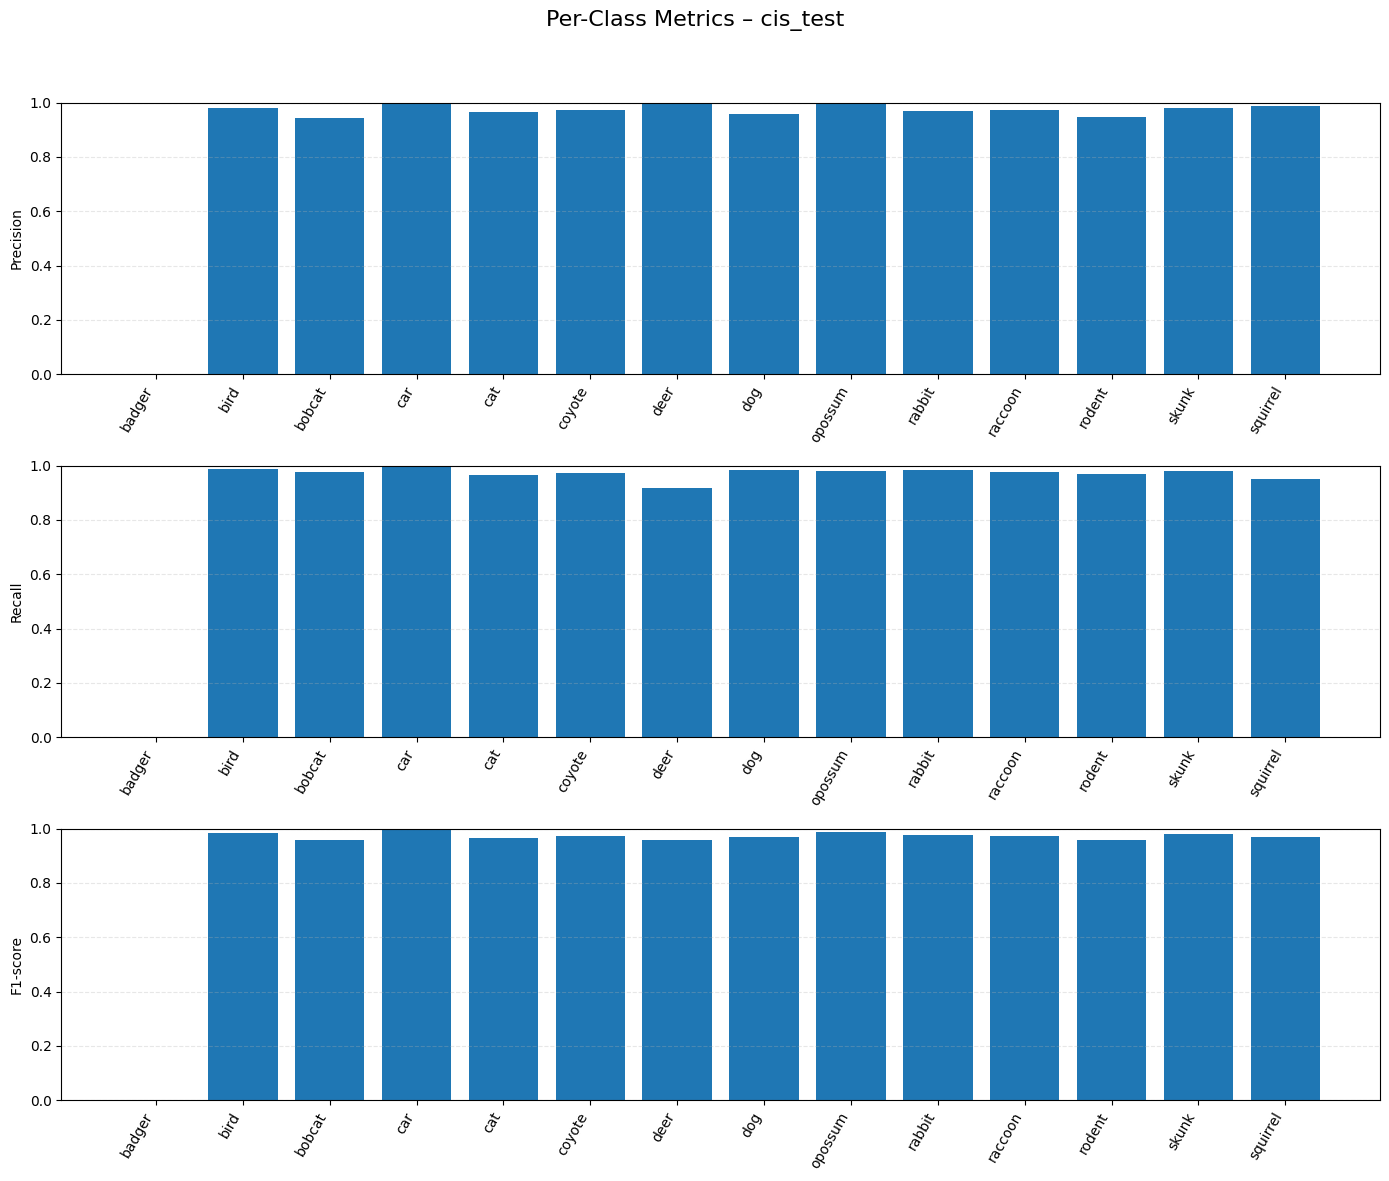

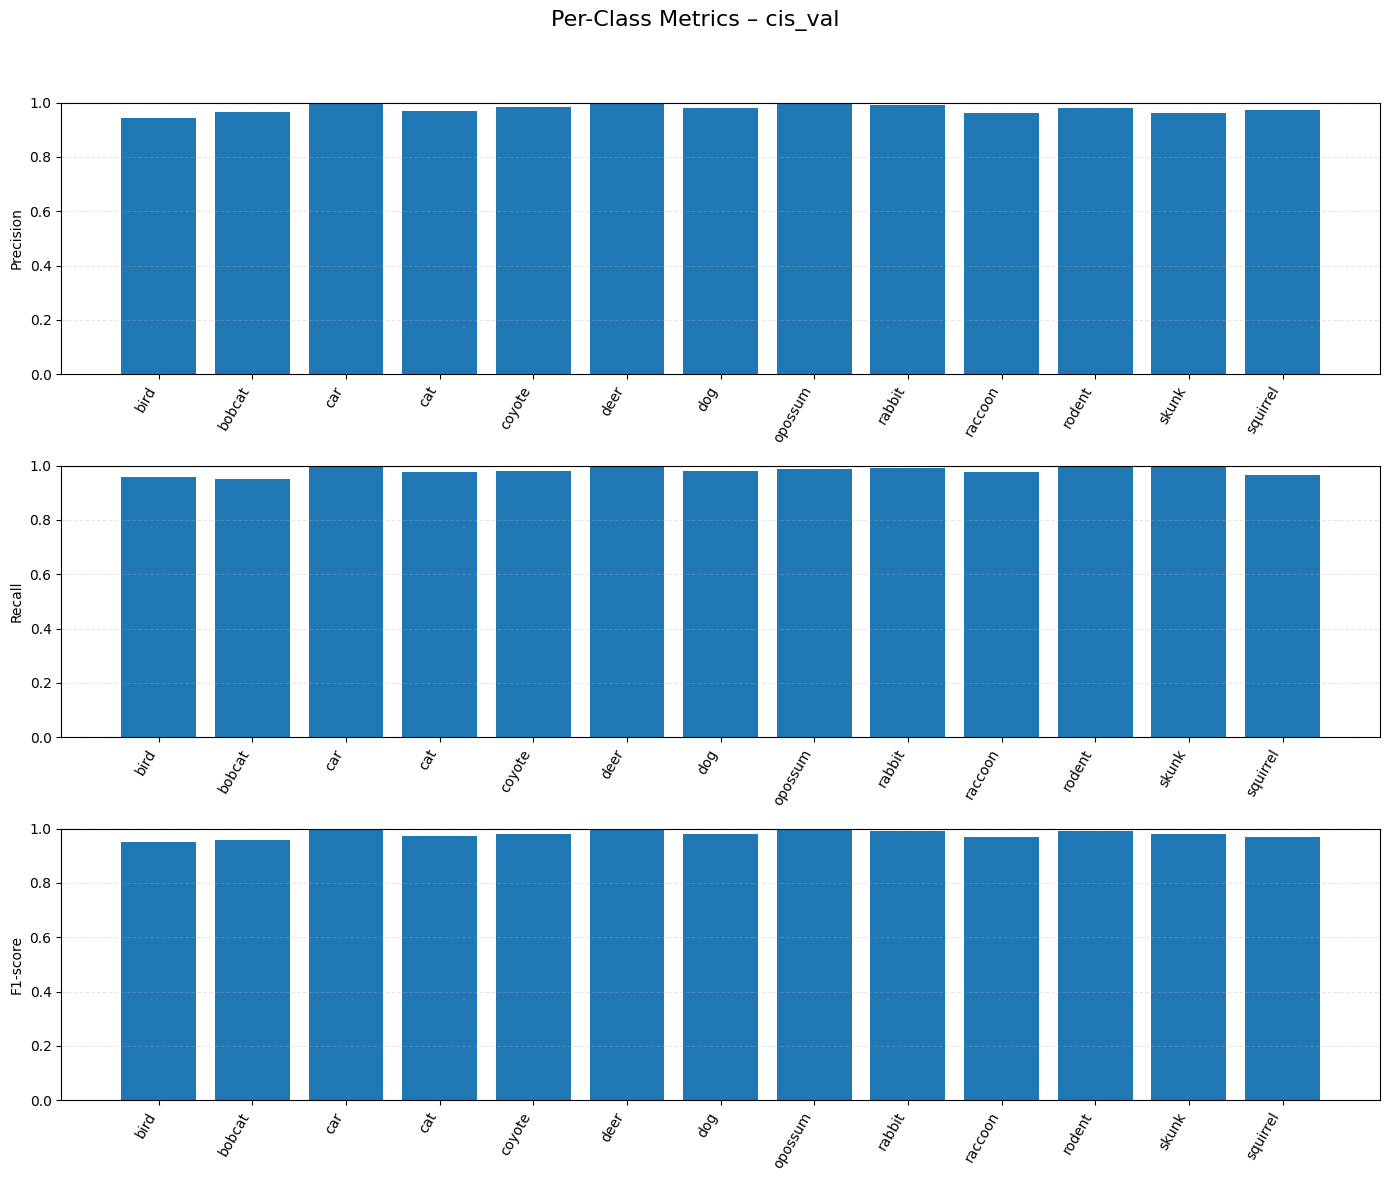

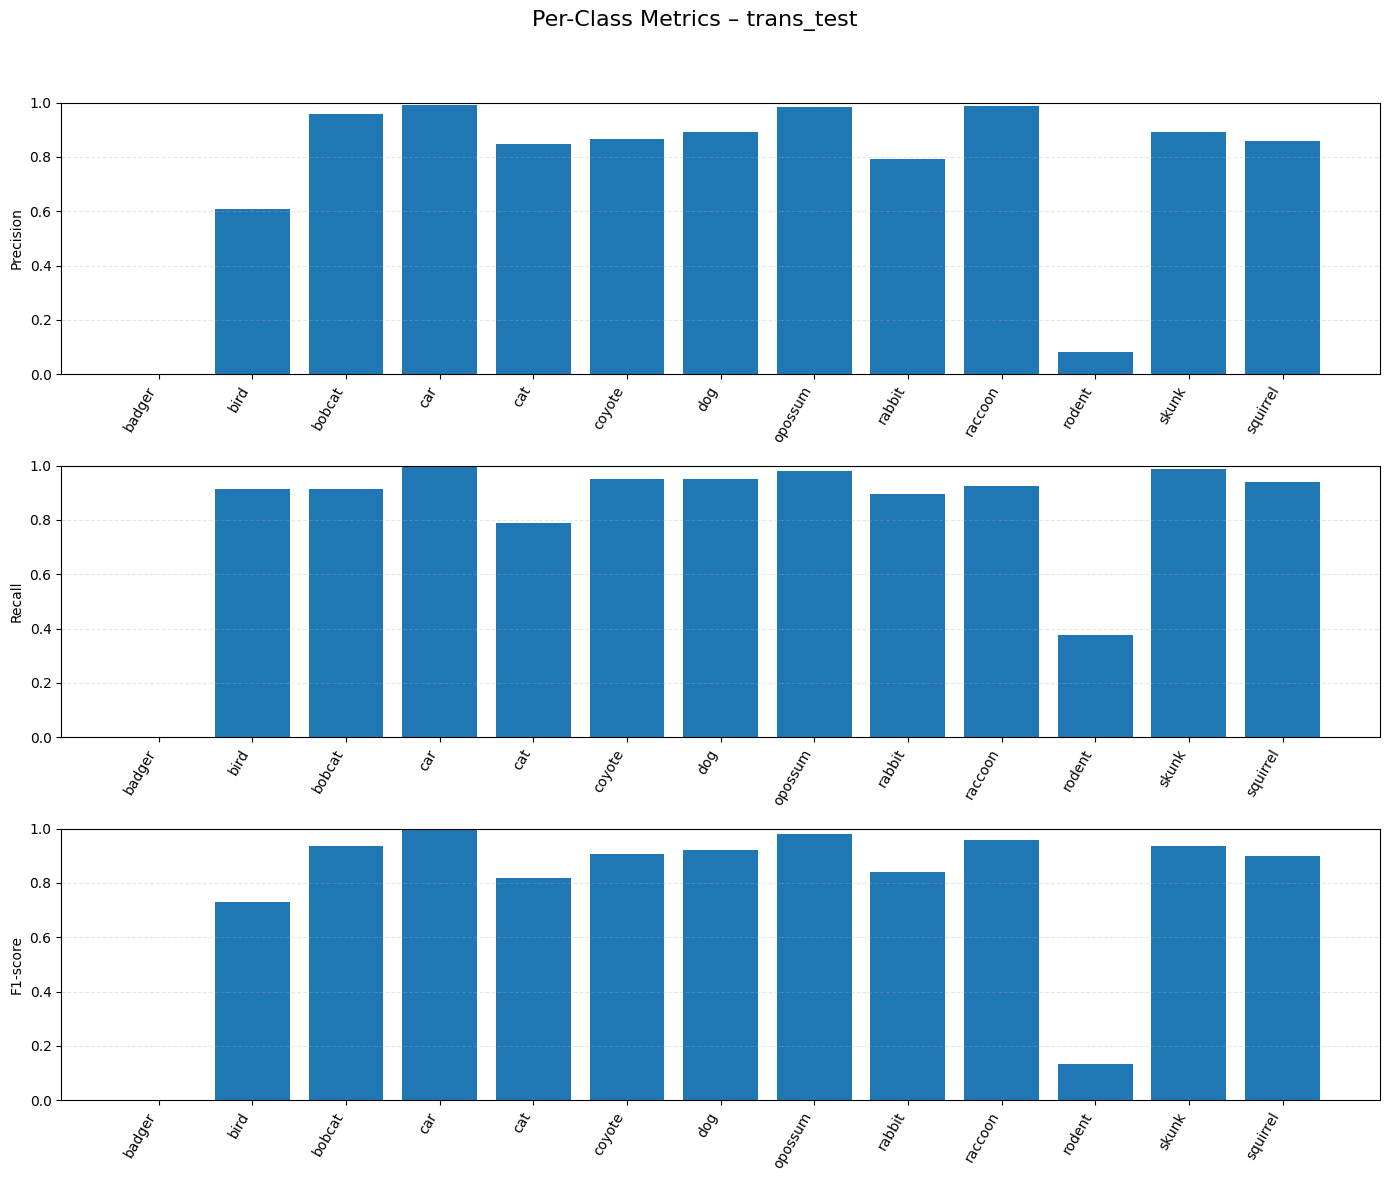

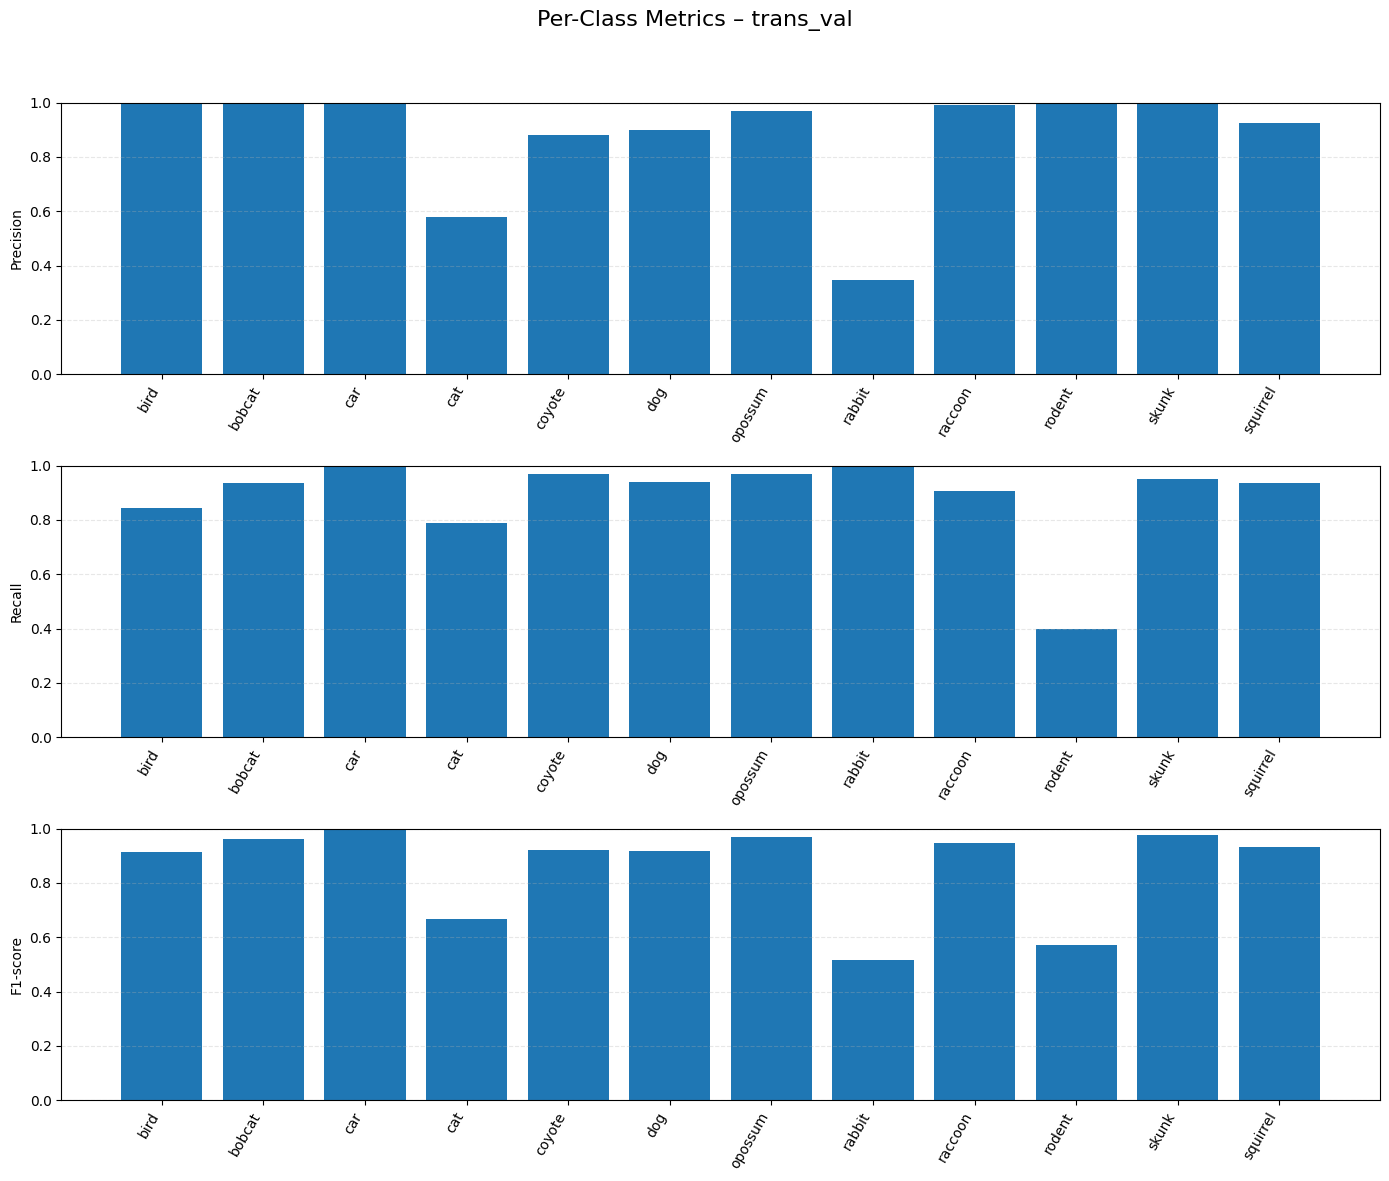

In [35]:


REP_DIR  = "eval/pipeline_results/eval_reports"
reports  = glob.glob(os.path.join(REP_DIR, "*_classification_report.csv"))
metrics  = ["precision", "recall", "f1-score"]

for rpt in sorted(reports):
    split = os.path.basename(rpt).replace("_classification_report.csv", "")
    df    = pd.read_csv(rpt, index_col=0)

    # keep only real classes – drop global rows
    df = df.loc[~df.index.isin(["accuracy", "macro avg", "weighted avg"])]

    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(f"Per-Class Metrics – {split}", fontsize=16, y=0.98)

    for ax, m in zip(axes, metrics):
        vals  = df[m].fillna(0)
        x_pos = range(len(vals))

        ax.bar(x_pos, vals)
        ax.set_ylim(0, 1)
        ax.set_ylabel(m.capitalize())
        ax.grid(axis="y", ls="--", alpha=0.3)

        ax.set_xticks(x_pos)                               # fixed locator
        ax.set_xticklabels(vals.index, rotation=60, ha="right")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()
